In [1]:
import sys
sys.path.append('../utils')
import os

# Importing importlib for module reloading
import importlib
import image_cropp_utils

# Reloading the module
importlib.reload(image_cropp_utils)
from image_cropp_utils import load_dataframe, get_barcode_coordinates, calculate_one_micron, read_microns_per_pixel


In [2]:
df = load_dataframe('../data/raw/p5/binned_outputs/square_002um/spatial/tissue_positions.parquet')

In [3]:
json_path = '/Users/lollijagladiseva/Desktop/cellseg_visium_hd/data/raw/p5/binned_outputs/square_002um/spatial/scalefactors_json.json'
microns_per_pixel = read_microns_per_pixel(json_path)

In [4]:
one_micron = calculate_one_micron(microns_per_pixel)

In [5]:
first_barcode_pxl_row, first_barcode_pxl_col, last_barcode_pxl_row, last_barcode_pxl_col = get_barcode_coordinates(df, one_micron)

In [6]:
import scanpy as sc

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata
import geopandas as gpd

from stardist.models import StarDist2D

from tifffile import imread, imwrite
from csbdeep.utils import normalize
from shapely.geometry import Polygon, Point
from scipy import sparse
from matplotlib.colors import ListedColormap

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

2024-08-18 12:19:26.975460: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
# Load the image file
# Change dir_base as needed to the directory where the downloaded example data is stored
dir_base = '../data/raw/p5/'
filename = 'Visium_HD_Human_Colon_Cancer_P5_tissue_image.btf'
img = imread(dir_base + filename)

# Load the pretrained model
model = StarDist2D.from_pretrained('2D_versatile_he')

# Percentile normalization of the image
# Adjust min_percentile and max_percentile as needed
min_percentile = 5
max_percentile = 95
img = normalize(img, min_percentile, max_percentile)



Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


In [14]:
output_dir = '../data/processed/p5_stardist_whole/'
output_filename = 'normalized_image.tiff'
output_path = output_dir + output_filename

# Save the normalized image
imwrite(output_path, img)

In [15]:
labels, polys = model.predict_instances_big(img, 
                                            axes='YXC', 
                                            block_size=4096, 
                                            prob_thresh=0.01,
                                            nms_thresh=0.001, 
                                            min_overlap=128, 
                                            context=128, 
                                            normalizer=None, 
                                            n_tiles=(4,4,1))

effective: block_size=(4096, 4096, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)


python(13875) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 360/360 [3:29:46<00:00, 34.96s/it]  


In [16]:
geometries = []

# Iterating through each nuclei in the 'polys' DataFrame
for nuclei in range(len(polys['coord'])):

    # Extracting coordinates for the current nuclei and converting them to (y, x) format
    coords = [(y, x) for x, y in zip(polys['coord'][nuclei][0], polys['coord'][nuclei][1])]

    # Creating a Polygon geometry from the coordinates
    geometries.append(Polygon(coords))

# Creating a GeoDataFrame using the Polygon geometries
gdf = gpd.GeoDataFrame(geometry=geometries)
gdf['id'] = [f"ID_{i+1}" for i, _ in enumerate(gdf.index)]

In [17]:
gdf.to_file('../data/processed/p5_stardist_whole/stardist_all.geojson', driver='GeoJSON')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


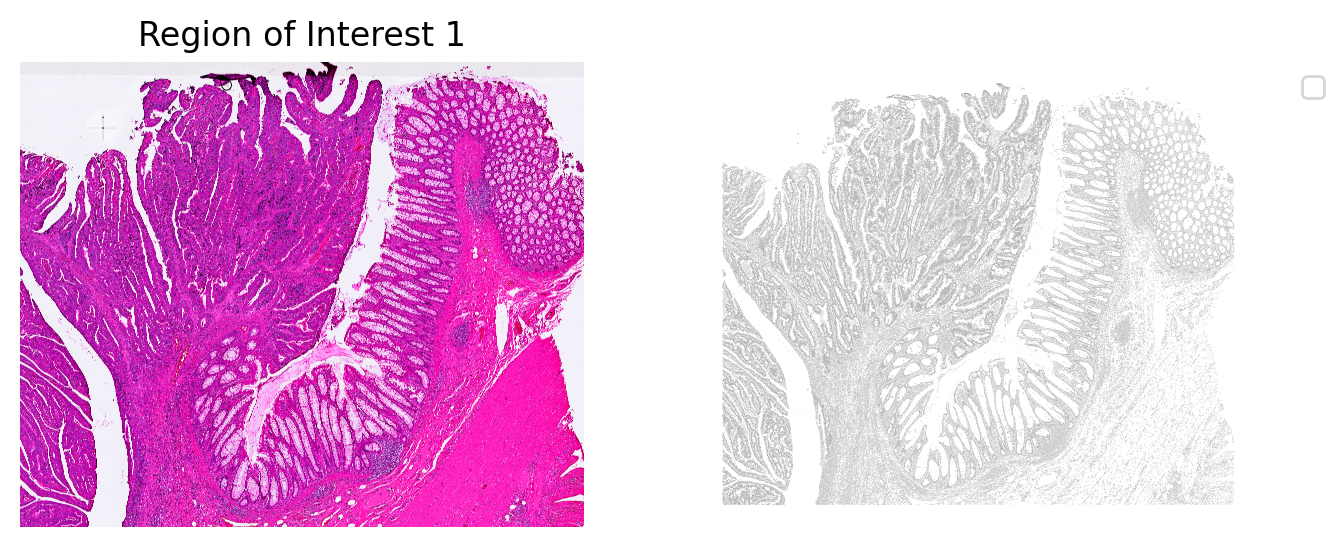

In [25]:
import image_plot_utils

# Reloading the module
importlib.reload(image_plot_utils)
from image_plot_utils import plot_mask_and_save_image
# Plot the nuclei segmentation
bbox=(last_barcode_pxl_row, first_barcode_pxl_col, first_barcode_pxl_row, last_barcode_pxl_col)

# Define a single color cmap
cmap=ListedColormap(['grey'])

# Create Plot
plot_mask_and_save_image(title="Region of Interest 1",gdf=gdf,bbox=bbox,cmap=cmap,img=img,output_name=dir_base+"image_mask.ROI1.tif")


In [27]:
# Load Visium HD data
raw_h5_file = '../data/raw/p5/binned_outputs/square_002um/filtered_feature_bc_matrix.h5'
adata = sc.read_10x_h5(raw_h5_file)

# Load the Spatial Coordinates
tissue_position_file = '../data/raw/p5/binned_outputs/square_002um/spatial/tissue_positions.parquet'
df_tissue_positions=pd.read_parquet(tissue_position_file)

#Set the index of the dataframe to the barcodes
df_tissue_positions = df_tissue_positions.set_index('barcode')

# Create an index in the dataframe to check joins
df_tissue_positions['index']=df_tissue_positions.index

# Adding the tissue positions to the meta data
adata.obs =  pd.merge(adata.obs, df_tissue_positions, left_index=True, right_index=True)

# Create a GeoDataFrame from the DataFrame of coordinates
geometry = [Point(xy) for xy in zip(df_tissue_positions['pxl_col_in_fullres'], df_tissue_positions['pxl_row_in_fullres'])]
gdf_coordinates = gpd.GeoDataFrame(df_tissue_positions, geometry=geometry)


anndata.py (1820): Variable names are not unique. To make them unique, call `.var_names_make_unique`.
anndata.py (1820): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [28]:
# Perform a spatial join to check which coordinates are in a cell nucleus
result_spatial_join = gpd.sjoin(gdf_coordinates, gdf, how='left', predicate='within')

# Identify nuclei associated barcodes and find barcodes that are in more than one nucleus
result_spatial_join['is_within_polygon'] = ~result_spatial_join['index_right'].isna()
barcodes_in_overlaping_polygons = pd.unique(result_spatial_join[result_spatial_join.duplicated(subset=['index'])]['index'])
result_spatial_join['is_not_in_an_polygon_overlap'] = ~result_spatial_join['index'].isin(barcodes_in_overlaping_polygons)

# Remove barcodes in overlapping nuclei
barcodes_in_one_polygon = result_spatial_join[result_spatial_join['is_within_polygon'] & result_spatial_join['is_not_in_an_polygon_overlap']]

# The AnnData object is filtered to only contain the barcodes that are in non-overlapping polygon regions
filtered_obs_mask = adata.obs_names.isin(barcodes_in_one_polygon['index'])
filtered_adata = adata[filtered_obs_mask,:]

# Add the results of the point spatial join to the Anndata object
filtered_adata.obs =  pd.merge(filtered_adata.obs, barcodes_in_one_polygon[['index','geometry','id','is_within_polygon','is_not_in_an_polygon_overlap']], left_index=True, right_index=True)


anndata.py (1820): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [29]:
# Group the data by unique nucleous IDs
groupby_object = filtered_adata.obs.groupby(['id'], observed=True)

# Extract the gene expression counts from the AnnData object
counts = filtered_adata.X

# Obtain the number of unique nuclei and the number of genes in the expression data
N_groups = groupby_object.ngroups
N_genes = counts.shape[1]

# Initialize a sparse matrix to store the summed gene counts for each nucleus
summed_counts = sparse.lil_matrix((N_groups, N_genes))

# Lists to store the IDs of polygons and the current row index
polygon_id = []
row = 0

# Iterate over each unique polygon to calculate the sum of gene counts.
for polygons, idx_ in groupby_object.indices.items():
    summed_counts[row] = counts[idx_].sum(0)
    row += 1
    polygon_id.append(polygons)

# Create and AnnData object from the summed count matrix
summed_counts = summed_counts.tocsr()
grouped_filtered_adata = anndata.AnnData(X=summed_counts,obs=pd.DataFrame(polygon_id,columns=['id'],index=polygon_id),var=filtered_adata.var)

%store grouped_filtered_adata


anndata.py (1820): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Stored 'grouped_filtered_adata' (AnnData)


In [30]:
grouped_filtered_adata.write("../data/processed/p5_stardist_whole/grouped_filtered_adata.h5ad")

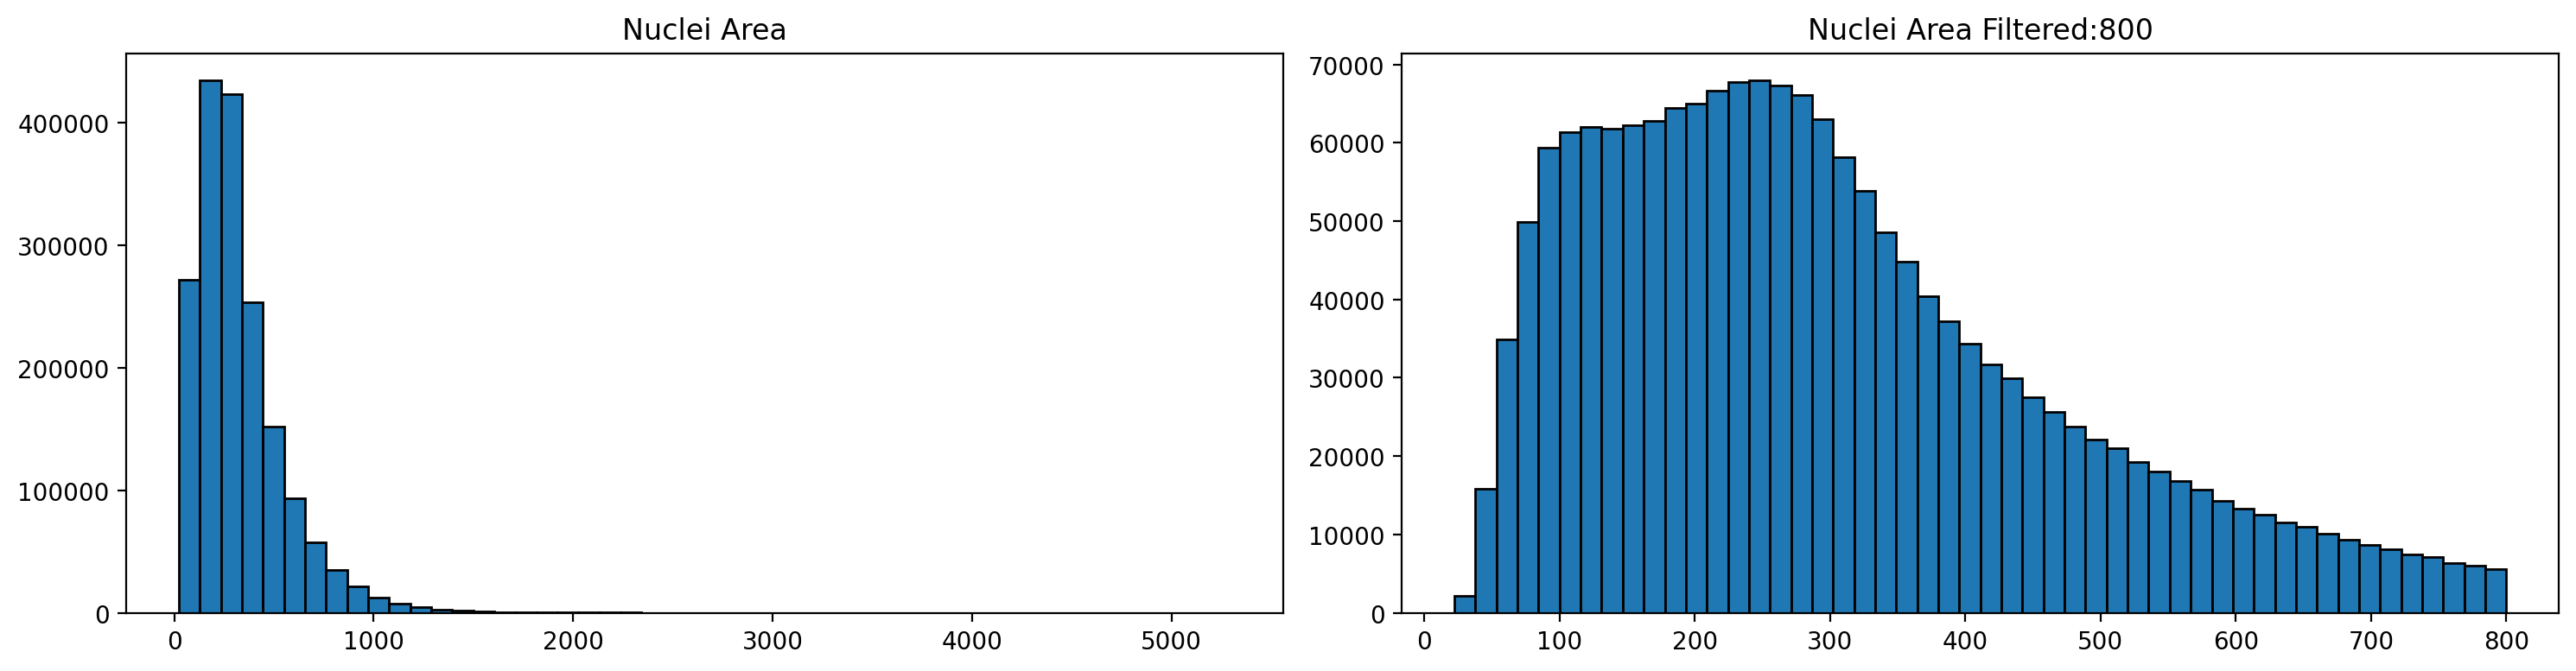

In [35]:
from image_plot_utils import plot_nuclei_area
# Store the area of each nucleus in the GeoDataframe
gdf['area'] = gdf['geometry'].area

# Calculate quality control metrics for the original AnnData object
sc.pp.calculate_qc_metrics(grouped_filtered_adata, inplace=True)

# Plot the nuclei area distribution before and after filtering
plot_nuclei_area(gdf=gdf,area_cut_off=1100)


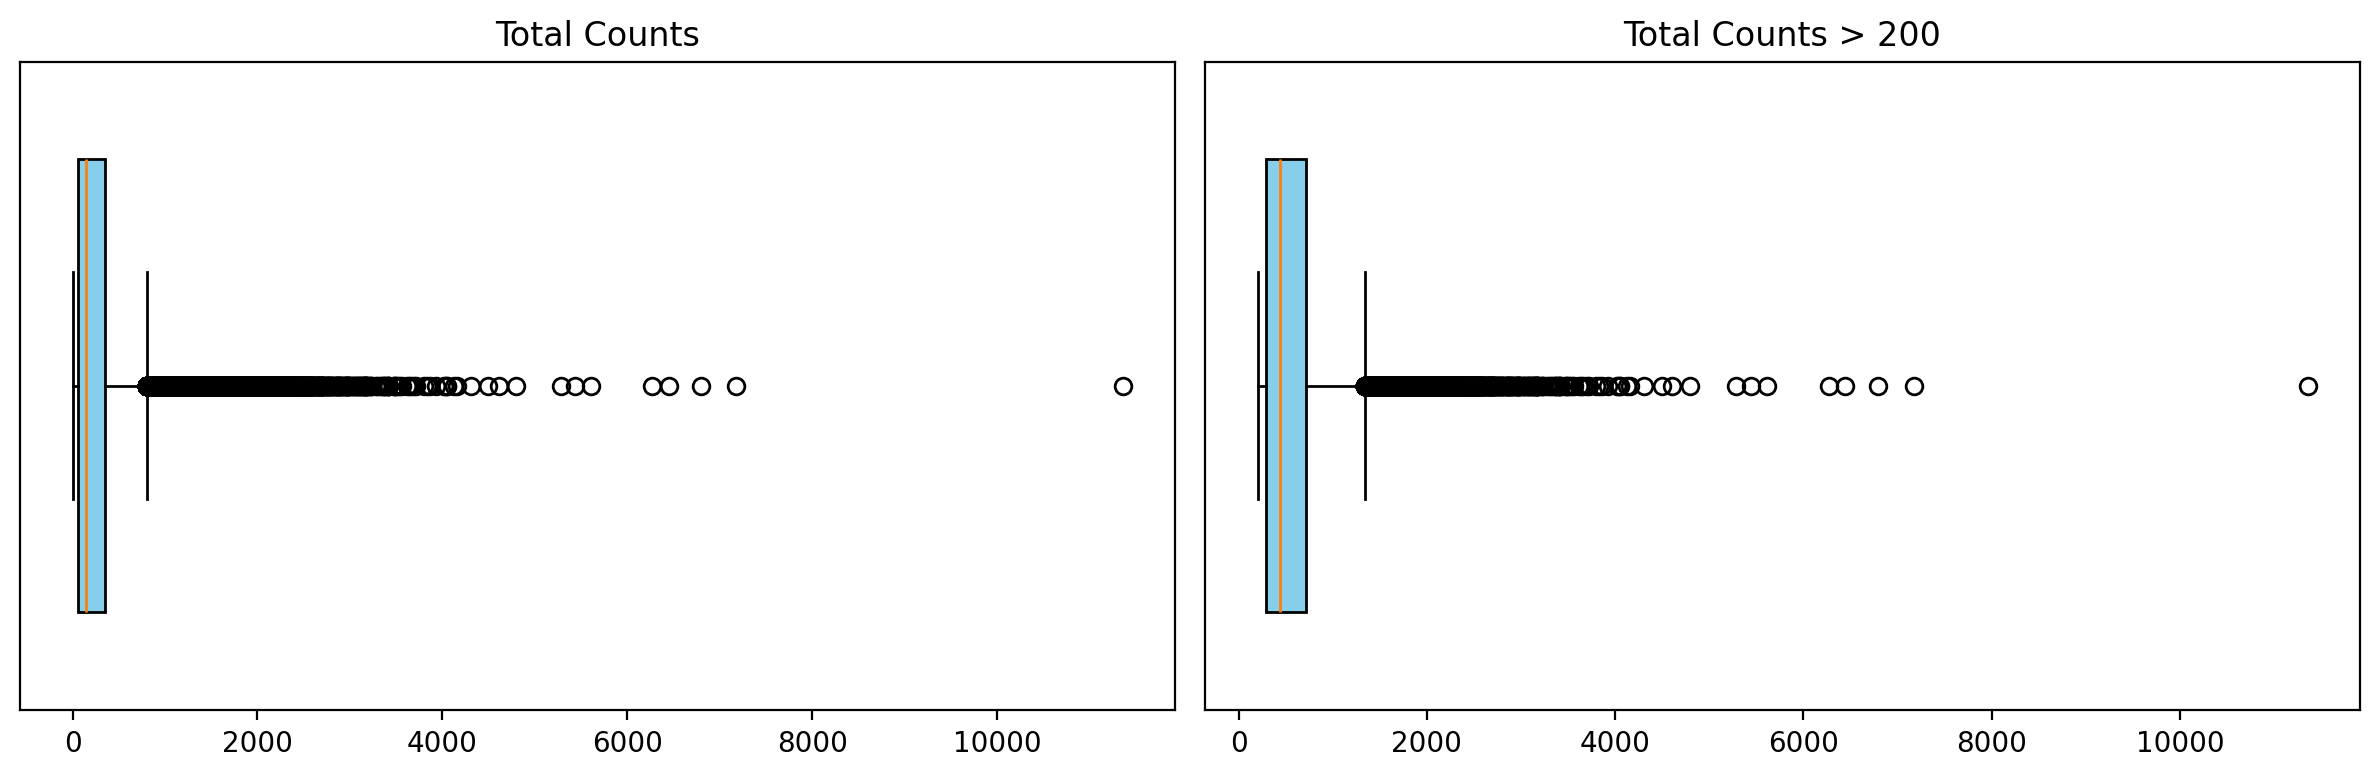

In [37]:
from image_plot_utils import total_umi
# Plot total UMI distribution
total_umi(grouped_filtered_adata, 200)


In [38]:
# Create a mask based on the 'id' column for values present in 'gdf' with 'area' less than 500
mask_area = grouped_filtered_adata.obs['id'].isin(gdf[gdf['area'] < 500].id)

# Create a mask based on the 'total_counts' column for values greater than 100
mask_count = grouped_filtered_adata.obs['total_counts'] > 100

# Apply both masks to the original AnnData to create a new filtered AnnData object
count_area_filtered_adata = grouped_filtered_adata[mask_area & mask_count, :]

# Calculate quality control metrics for the filtered AnnData object
sc.pp.calculate_qc_metrics(count_area_filtered_adata, inplace=True)


_qc.py (141): Trying to modify attribute `.obs` of view, initializing view as actual.
anndata.py (1820): Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [39]:
 # Normalize total counts for each cell in the AnnData object
sc.pp.normalize_total(count_area_filtered_adata, inplace=True)

# Logarithmize the values in the AnnData object after normalization
sc.pp.log1p(count_area_filtered_adata)

# Identify highly variable genes in the dataset using the Seurat method
sc.pp.highly_variable_genes(count_area_filtered_adata, flavor="seurat", n_top_genes=2000)

# Perform Principal Component Analysis (PCA) on the AnnData object
sc.pp.pca(count_area_filtered_adata)

# Build a neighborhood graph based on PCA components
sc.pp.neighbors(count_area_filtered_adata)

# Perform Leiden clustering on the neighborhood graph and store the results in 'clusters' column

# Adjust the resolution parameter as needed for different samples
sc.tl.leiden(count_area_filtered_adata, resolution=0.35, key_added="clusters")


_index.py (146): Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
1795262585.py (19): In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


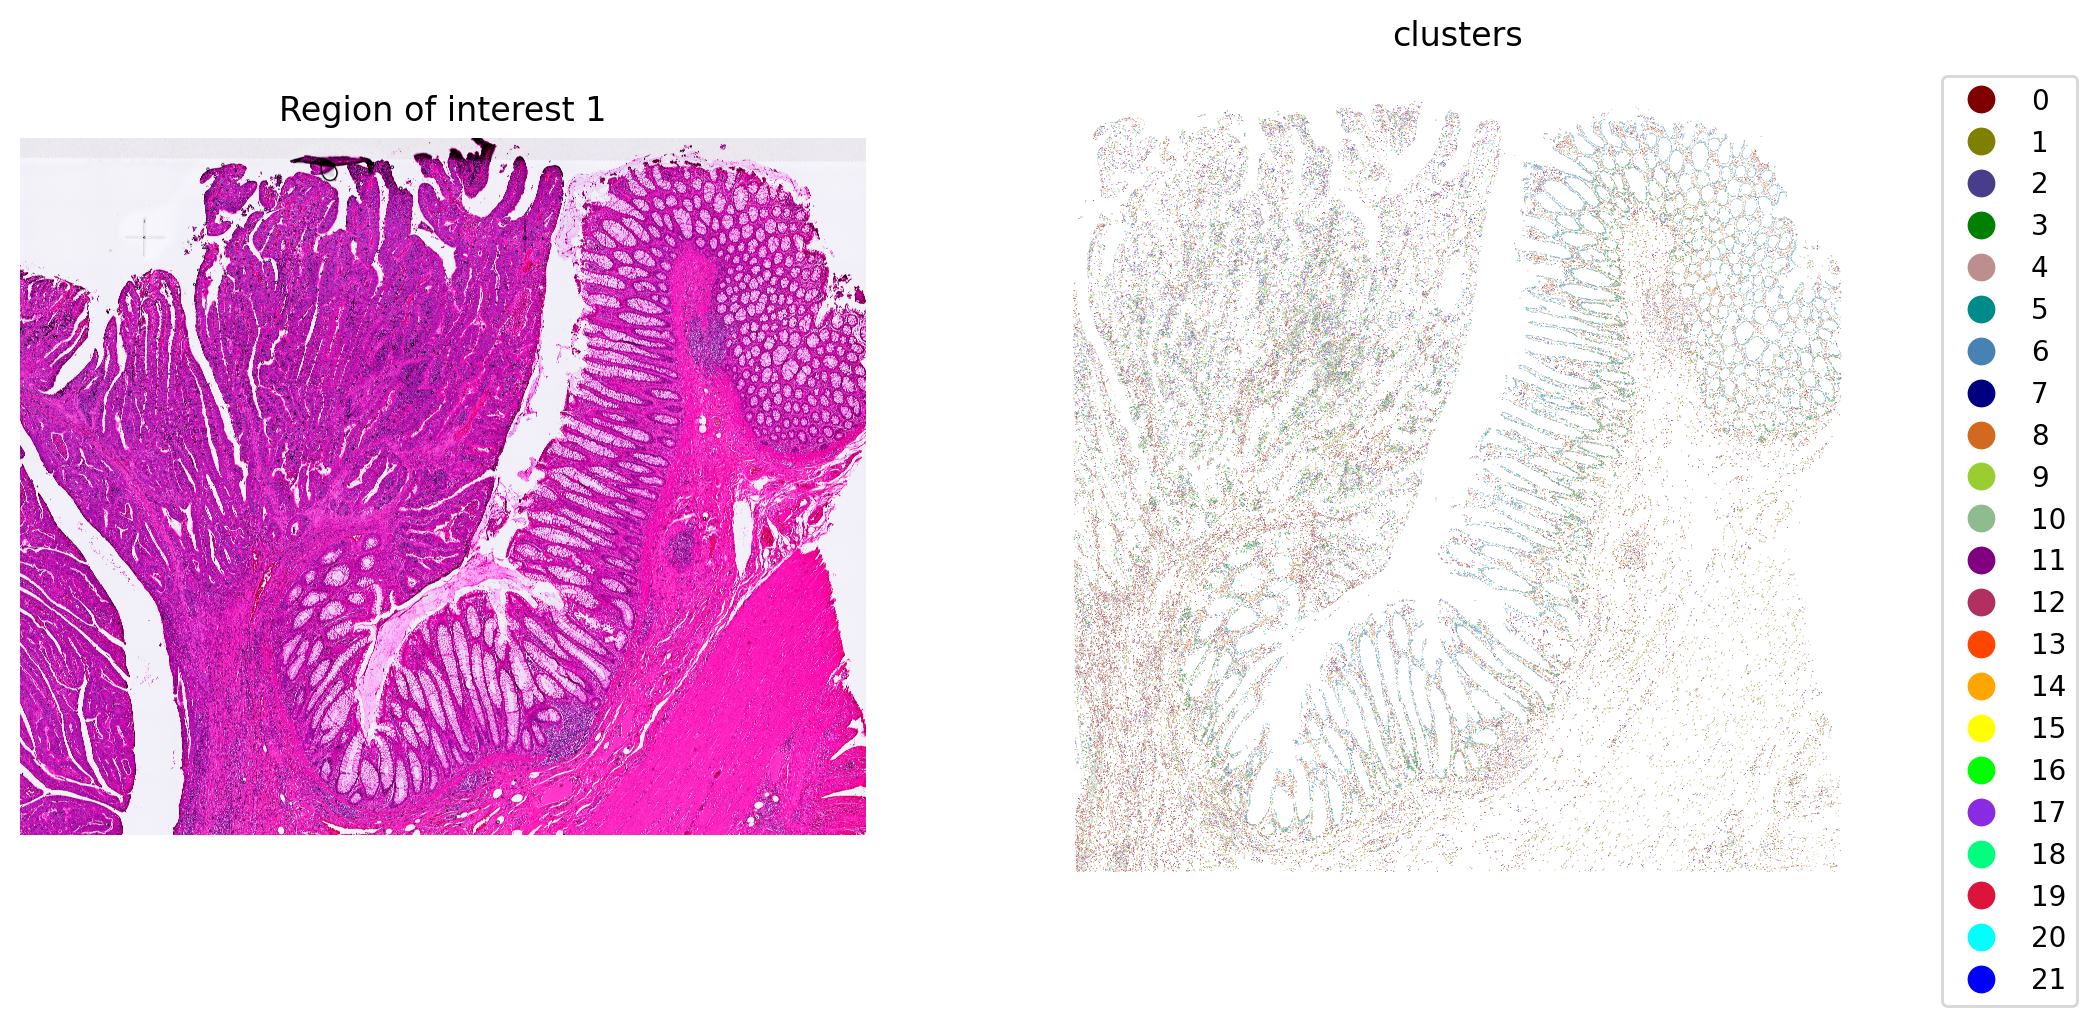

In [42]:
from image_plot_utils import plot_clusters_and_save_image
importlib.reload(image_plot_utils)
# Plot and save the clustering results
plot_clusters_and_save_image(title="Region of interest 1", gdf=gdf, img=img, adata=count_area_filtered_adata, bbox=bbox, color_by_obs='clusters', output_name=dir_base+"image_clustering.ROI1.tiff")